# Original paper: https://www.tensorflow.org/tutorials/generative/dcgan

In [1]:
import tensorflow as tf

In [2]:
# tf version check
tf.__version__

'2.15.0'

In [5]:
# To generate GIFs
#pip install imageio     ##### No need as it is included in Py library
# pip install git+https://github.com/tensorflow/docs

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Download and prepare the Dataset

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')  ## and resize image(28,28,1) and as_type() defindes float value
train_images = (train_images - 127.5) / 127.5                                            # Normalize the images to [-1, 1]

In [9]:
len(train_images)

60000

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) #  takes dataset as tensor
train_dataset = train_dataset.shuffle(BUFFER_SIZE)              # make dataset as shuffle
train_dataset = train_dataset.batch(BATCH_SIZE)                 # make dataset as batch wise
len(train_dataset)                                            # (60000 %256) gives total 235 data

235

# Create Generator Model
Important Note: The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Takes the noise seed as input, then upsampling several times untill reach a desired image size(28,28,1) using LeakyRelu activation. For final output, use tanh activation. because image range should -1 to 1.

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))         # input dim= (1,100) and batch= 256, kernel=(7,7)--> model summary
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))                                       # row= (7,7) and col= 256
    assert model.output_shape == (None, 7, 7, 256)                               # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  # use tanh because image range should -1 to 1.
    assert model.output_shape == (None, 28, 28, 1)                                # final output= (28,28,1)

    return model

# (as yet untrained) generator to create an image

(1, 100)
(1, 28, 28, 1)


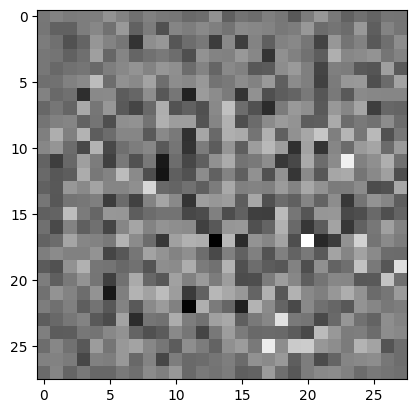

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
print(noise.shape)                                    # because model input dim= (1,100)
generated_image = generator(noise, training=False)
print(generated_image.shape)                           # because model out dim= (1, 28, 28, 1)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
# print Generator model
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

#Create Discriminator Model
Important Note: Discriminator takes the generated output from generator model as an input. Then pass this input and output image

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))                                 # Dropout for avaoid overfitting

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
  # model.add(layers.Dense(1))                           # it was original paper
    model.add(layers.Dense(1, activation="sigmoid"))   # because output provides 0 to 1

    return model

# (as yet untrained) discriminator to classify the generated images as real or fake.
The model will be trained to output positive values for real images, and negative values for fake images.

In [16]:
discriminator = make_discriminator_model()
print(discriminator)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50036925]], shape=(1, 1), dtype=float32)


In [17]:
# print Discriminator model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

# Defined all loss function

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)    # it is Binary classifiaction

# Discriminator loss:
It compares the discriminator's predictions on real images to an array of 1s--> (tf.ones_like()), and the discriminator's predictions on fake (generated) images to an array of 0s-->(tf.zeross_like()).

In [19]:
def discriminator_loss(real_output, fake_output):
    ## real_loss gives real loss volue between ones_like vs real_output,Here, ones_like(real_output)-->our  desire real output
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    ## Fake_loss gives fake loss volue between zero_like vs fake_output, Here, zeros_like(fake_output)-->our  desire fake output
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss:
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s

# if generator is good generator, it will make fool the discriminator and output of discriminator is 1.Then discriminator unable to distingushed. Finally cross entropy loss of generator will be zero.

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)   # generator lass takes fake image how well ca generator image
    # if generator is good generator, it will make fool the discriminator and output of discriminator is 1.Then discriminator unable to distingushed.

# Use two separate Optimizers:

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Save checkpoints:

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Create and Run the Training loop:
1. The training loop begins with generator receiving a random seed as input, conseuently produce an image.
2. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
3. The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [23]:
# define training paramets:

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)             # This require during testing time
# to visualize progress in the animated GIF)                      # This require during testing time

seed = tf.random.normal([num_examples_to_generate, noise_dim])     # This require during testing time


In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function
def train_step(images):                                                       # images == train  images
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:       # defiene two separate Gradients

      generated_images = generator(noise, training=True)                      # this generates noise image from noise

      real_output = discriminator(images, training=True)                      # this generates Real image from MNIST data
      fake_output = discriminator(generated_images, training=True)            # this generates Fake image from noise

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)            # update gradients for generator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # update gradients for Discriminator

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))   # update optimizer direct form of Tf
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Run training:

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()                        ### record training time

    for image_batch in dataset:                ### get each batch with loop
      train_step(image_batch)

    ### Produce images for the GIF as you go
    display.clear_output(wait=True)           ### clear previous images
    generate_and_save_images(generator,       ### each epoch observe  saved generator image
                             epoch + 1,
                             seed)

    #### Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #### Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate and save images:

In [26]:
def generate_and_save_images(model, epoch, test_input):         ###  test_input== seed which from "define training paramets:" paragraph

  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):                            ### Plot 4, 4 images
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Finally welcome to Run the training the model
Call the train() method defined above to train the generator and discriminator simultaneously.
At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

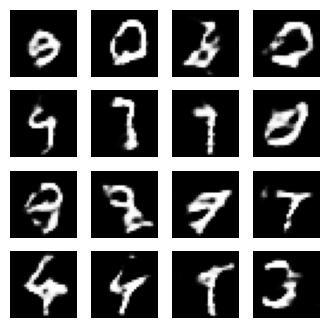

In [27]:
train(train_dataset, EPOCHS)

# Restore the latest checkpoint.

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

'# Create a GIF for testing

In [30]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

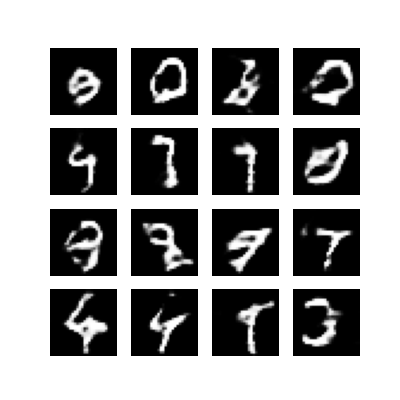

In [31]:
display_image(EPOCHS)

# Use "imageio" to create an animated gif using the images saved during training.

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-32-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-32-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [33]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'

# Next steps:
As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset available on Kaggle.https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
To learn more about GANs see the NIPS 2016 Tutorial: Generative Adversarial Networks.